In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

In [121]:
data = pd.read_csv('./train.csv')

# Feature Evaluation

In [122]:
print('P_Class:',data['Pclass'].unique())
print('Sex:',data['Sex'].unique())
print('Sibling/Spouse:',data['SibSp'].max())
print('Parents/Children:',data['Parch'].max())
print('Age:',data['Age'].min(),data['Age'].max())
print('Embarked:',data['Embarked'].unique())
print(data['Age'].isna().sum(),data['Age'].count(),data[~data['Age'].isnull()].shape)

P_Class: [3 1 2]
Sex: ['male' 'female']
Sibling/Spouse: 8
Parents/Children: 6
Age: 0.42 80.0
Embarked: ['S' 'C' 'Q' nan]
177 714 (714, 12)


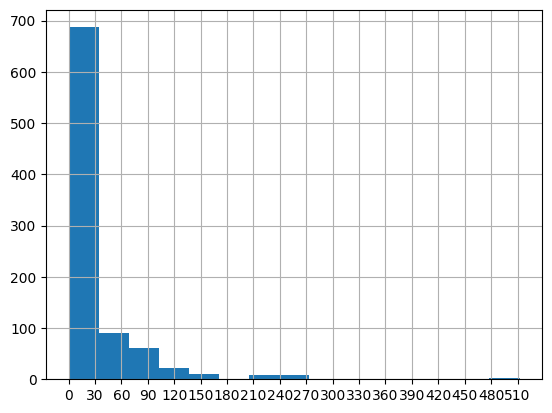

In [123]:
data['Fare'].hist(bins=15)
plt.xticks(np.arange(0, data['Fare'].max()+10, 30))
plt.show()

In [124]:
# Tests
from scipy.stats import chi2_contingency,spearmanr,ttest_ind
from sklearn.feature_selection import mutual_info_classif
contingency = pd.crosstab(data['Sex'], data['Survived'])
chi2, p, dof, expected = chi2_contingency(contingency)
print("Chi-square (Sex):", chi2, " p-value:", p)

contingency = pd.crosstab(data['Embarked'], data['Survived'])
chi2, p, dof, expected = chi2_contingency(contingency)
print("Chi-square (Embarked):", chi2, " p-value:", p)

def cramers_v(x, y):
    contingency = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency)[0]
    n = contingency.sum().sum()
    r, k = contingency.shape
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))

print("Cramér’s V (Sex):", cramers_v(data['Sex'], data['Survived']))

print("Cramér’s V (Embarked):", cramers_v(data['Embarked'], data['Survived']))

rho, p = spearmanr(data['Pclass'], data['Survived'])
print("Spearman correlation (P-class):", rho, " p-value:", p)

rho, p = spearmanr(data['SibSp'], data['Survived'])
print("Spearman correlation (Sibling/Spouse):", rho, " p-value:", p)

rho, p = spearmanr(data['Parch'], data['Survived'])
print("Spearman correlation (Parents/Children):", rho, " p-value:", p)

non_null_data = data[~data['Age'].isnull()]
group0 = non_null_data.loc[non_null_data['Survived']==0, 'Age']
group1 = non_null_data.loc[non_null_data['Survived']==1, 'Age']
t_stat, p = ttest_ind(group0, group1, equal_var=False)
print(f"t-stat (Age):", t_stat, "p-value:",p)


mi = mutual_info_classif(non_null_data[['Age']], non_null_data['Survived'])
print("Mutual Information (Age):", mi[0])

Chi-square (Sex): 260.71702016732104  p-value: 1.1973570627755645e-58
Chi-square (Embarked): 26.48914983923762  p-value: 1.769922284120912e-06
Cramér’s V (Sex): 0.5409359434469282
Cramér’s V (Embarked): 0.17261682709984438
Spearman correlation (P-class): -0.33966793665005257  p-value: 1.6876081409966055e-25
Spearman correlation (Sibling/Spouse): 0.08887948468090501  p-value: 0.007941431285733533
Spearman correlation (Parents/Children): 0.13826563286545587  p-value: 3.453591460380432e-05
t-stat (Age): 2.0460301043939704 p-value: 0.04118965162586639
Mutual Information (Age): 0.031539210985839894


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Model

## Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


### Feature Engineering

In [ ]:
X = pd.get_dummies(data,columns=['Sex','Embarked']).loc[:,['PassengerId','Pclass','Age','SibSp','Parch','Fare','Sex_female','Sex_male','Embarked_C','Embarked_Q','Embarked_S']]
X.set_index('PassengerId',inplace=True)
y = data[['PassengerId','Survived']]
y.set_index('PassengerId',inplace = True)

In [78]:
imputer = SimpleImputer(strategy='most_frequent')
X['Age'] = imputer.fit_transform(X[['Age']])
X['Age'] = imputer.transform(X[['Age']])
scaler = StandardScaler()
X[['Age','Fare']] = scaler.fit_transform(X[['Age','Fare']])
X[['Age','Fare']] = scaler.transform(X[['Age','Fare']])

### Learning curves

In [89]:
train_sizes, train_scores, val_scores = learning_curve(
    LogisticRegression(tol=1e-12),
    X, y,
    cv=5, scoring='recall',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

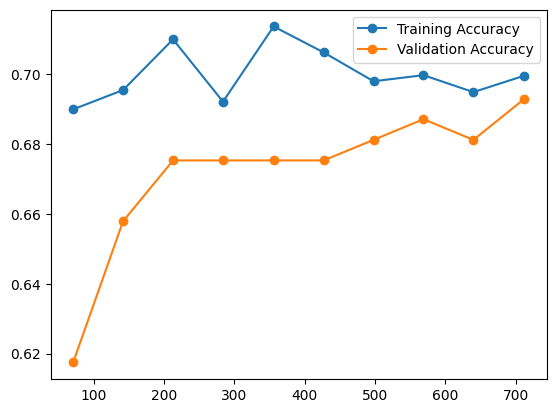

In [90]:
# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.legend()

### Test

In [54]:
model = LogisticRegression(tol=1e-12)
model.fit(X,y)


,penalty,'l2'
,dual,False
,tol,1e-12
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [91]:
test_data = pd.read_csv('test.csv')
X_test = pd.get_dummies(test_data,columns=['Sex','Embarked']).loc[:,['PassengerId','Pclass','Age','SibSp','Parch','Fare','Sex_female','Sex_male','Embarked_C','Embarked_Q','Embarked_S']]
X_test.set_index('PassengerId',inplace=True)
X_test['Age'] = imputer.transform(X_test[['Age']])
X_test[['Age','Fare']] = scaler.transform(X_test[['Age','Fare']])
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         418 non-null    float64
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        417 non-null    float64
 5   Sex_female  418 non-null    bool   
 6   Sex_male    418 non-null    bool   
 7   Embarked_C  418 non-null    bool   
 8   Embarked_Q  418 non-null    bool   
 9   Embarked_S  418 non-null    bool   
dtypes: bool(5), float64(2), int64(3)
memory usage: 21.6 KB


In [92]:
imputer2 = SimpleImputer(strategy='mean')
imputer2.fit(X[['Fare']])
X_test['Fare'] = imputer2.transform(X_test[['Fare']])
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         418 non-null    float64
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        418 non-null    float64
 5   Sex_female  418 non-null    bool   
 6   Sex_male    418 non-null    bool   
 7   Embarked_C  418 non-null    bool   
 8   Embarked_Q  418 non-null    bool   
 9   Embarked_S  418 non-null    bool   
dtypes: bool(5), float64(2), int64(3)
memory usage: 21.6 KB


In [ ]:
model = LogisticRegression(tol=1e-12)
model.fit(X, y)
train_score = model.score(X, y)
print(train_score)
y_test = model.predict(X_test)

0.8013468013468014


In [112]:
pd.concat([pd.Series(X_test.index),pd.Series(y_test,name = 'Survived')],axis = 1).set_index('PassengerId').to_csv('y_test.csv')

## XGBoost

In [ ]:
data.set_index('PassengerId',inplace=True)
data = pd.get_dummies(data,columns = ['Sex','Embarked'])

In [129]:
X = data.loc[:,['Pclass','Age','SibSp','Parch','Fare','Sex_female','Sex_male','Embarked_C','Embarked_Q','Embarked_S']]
y = data['Survived']

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}
grid = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False),
    param_grid=params,
    scoring='accuracy',
    cv=5,
    verbose=1
)

grid.fit(X, y)
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.8744748980928267


In [135]:
model = xgb.XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.2,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X,y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [137]:
test_data = pd.read_csv('test.csv').set_index('PassengerId')
test_data = pd.get_dummies(test_data,columns=['Sex','Embarked'])
X_test = test_data.loc[:,['Pclass','Age','SibSp','Parch','Fare','Sex_female','Sex_male','Embarked_C','Embarked_Q','Embarked_S']]

In [141]:
y_test = model.predict(X_test)
pd.Series(y_test,name = 'Survived',index = test_data.index).to_csv('y_test_xgboost.csv')

## XGBoost2

In [5]:
data = pd.read_csv('train.csv',index_col='PassengerId')
data['Sex'] = data['Sex'].map(lambda x: 1 if x.strip() == 'male' else 0)
data['Embarked'].value_counts()


Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [6]:
data['Embarked'] = data['Embarked'].fillna('S')
imputer = SimpleImputer(strategy='median')
data['Age'] = imputer.fit_transform(data[['Age']])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    int64  
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.5+ KB


In [7]:
data['Cabin'] = data['Cabin'].apply(lambda x:x[0] if type(x) == str else  x)

In [8]:
X = pd.get_dummies(data,columns=['Cabin','Embarked']).loc[:,['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin_A','Cabin_B','Cabin_C','Cabin_D','Cabin_E','Cabin_F','Cabin_G','Cabin_T','Embarked_C','Embarked_Q']]
y = data['Survived']


In [9]:
X['Family'] = X['SibSp'] + X['Parch'] + 1
X['Male class'] = X['Pclass']*X['Sex']

In [10]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}
grid = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False),
    param_grid=params,
    scoring='roc_auc',
    cv=5,
    verbose=1
)

grid.fit(X, y)
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best Score: 0.8737574115115821


In [262]:
model = xgb.XGBClassifier(objective='binary:logistic',
                          use_label_encoder = False, 
                          colsample_bytree = 1,
                          learning_rate = 0.1, 
                          max_depth = 3, 
                          n_estimators = 300,
                          subsample = 0.8)
model.fit(X,y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [263]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [264]:
test_data = pd.read_csv('test.csv',index_col='PassengerId')
test_data['Sex'] = test_data['Sex'].map(lambda x: 1 if x.strip() == 'male' else 0)
test_data['Age'] = imputer.transform(test_data[['Age']])
test_data['Fare']= imputer.fit_transform(test_data[['Fare']])
test_data['Cabin'] = test_data['Cabin'].apply(lambda x:x[0] if type(x) == str else  x)
X_test = pd.get_dummies(test_data,columns=['Cabin','Embarked']).loc[:,['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin_A','Cabin_B','Cabin_C','Cabin_D','Cabin_E','Cabin_F','Cabin_G','Embarked_C','Embarked_Q']]
X_test.insert(13,'Cabin_T',0)
X_test['Family'] = X_test['SibSp'] + X_test['Parch'] + 1
X_test['Male class'] = X_test['Pclass']*X_test['Sex']

In [268]:
pd.Series(model.predict(X_test),name = 'Survived',index = X_test.index).to_csv('y_test_xgboost2.csv')